# Automatic image classification (CNN approach)
Pierre-Yves BOISBUNON - April 2018

----------

In this notebook, we will classify previously prepared images (see **notebook_prepare_train_and_test.ipynb**) based on a Conventional Neuronal Network approch:
- Extract bottleneck feature
- First evaluation using simple Fully Connected layer
- Add Data Augmentation
- Improve Fully Connected layer
- Cross validation to optimise the optimiser

In [1]:
import os
import cv2
import math
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import GridSearchCV, RepeatedKFold, KFold
import pandas as pd
import shutil
import numpy as np
from sklearn.metrics import f1_score, confusion_matrix
import seaborn as sn

In [2]:
seed = 7
np.random.seed(seed)

In [3]:
# Disable GPU as my GPU card does not contain enough memory
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

In [4]:
from keras.applications.vgg16 import VGG16
from keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from keras.models import Sequential, Model
from keras.layers import Dropout, Flatten, Dense
from keras import applications
from keras import optimizers
from keras.utils import to_categorical
from keras import backend as K
from keras import callbacks
from keras.preprocessing.image import img_to_array, array_to_img
from keras.wrappers.scikit_learn import KerasClassifier
from keras import regularizers

C:\Users\boisb\Anaconda3\envs\py36\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [5]:
from tensorflow import set_random_seed
set_random_seed(2)

In [6]:
# Uncomment above line if you can use your own graphic card
# Allowing GPU memory growth
#cfg = K.tf.ConfigProto(gpu_options={'allow_growth': True})
#K.set_session(K.tf.Session(config=cfg))

# 1. Prepare images for Keras

In [7]:
input_train_path = 'dataset/train'
input_test_path = 'dataset/test'
output_path = 'data'
output_train_path = output_path + '/train'
output_test_path = output_path + '/test'

Let's prepare output train and test images based on our previous dataset resizing image in square image in 224x224.
For rectangular image, add black border.

In [8]:
def resize_image(image_input_path, image_output_path, desired_size=224):
    im = cv2.imread(image_input_path)
    old_size = im.shape[:2] # old_size is in (height, width) format
    ratio = float(desired_size)/max(old_size)
    new_size = tuple([int(x*ratio) for x in old_size])

    # new_size should be in (width, height) format
    im = cv2.resize(im, (new_size[1], new_size[0]))

    delta_w = desired_size - new_size[1]
    delta_h = desired_size - new_size[0]
    top, bottom = delta_h//2, delta_h-(delta_h//2)
    left, right = delta_w//2, delta_w-(delta_w//2)

    color = [0, 0, 0]
    new_im = cv2.copyMakeBorder(im, top, bottom, left, right, cv2.BORDER_CONSTANT,
        value=color)
    cv2.imwrite(image_output_path, new_im)
    

# Clean train and test folders first
shutil.rmtree(output_train_path, ignore_errors=True)
shutil.rmtree(output_test_path, ignore_errors=True)
shutil.rmtree(output_path, ignore_errors=True)
os.mkdir(output_path)
os.mkdir(output_train_path)
os.mkdir(output_test_path)

classes = os.listdir(input_train_path)
for cls in classes:
    # input_train_path
    image_output_path = output_train_path + os.sep + cls
    os.mkdir(image_output_path)
    image_input_path = input_train_path + os.sep + cls
    images = [filename for filename in os.listdir(image_input_path)]
    for im in images:
        resize_image( image_input_path + os.sep + im, image_output_path + os.sep + im)
    # input_test_path
    image_output_path = output_test_path + os.sep + cls
    os.mkdir(image_output_path)
    image_input_path = input_test_path + os.sep + cls
    images = [filename for filename in os.listdir(image_input_path)]
    for im in images:
        resize_image( image_input_path + os.sep + im, image_output_path + os.sep + im)     

Before importing Keras librairy, force seed to keep reproducibility.

Keras is using categorical matrix, let's build it based on image classes:

In [9]:
classes = os.listdir(output_train_path)
one_hot = pd.get_dummies(classes, sparse = True)
one_hot_labels = np.asarray(one_hot)
one_hot_labels

array([[1, 0, 0, 0, 0],
       [0, 1, 0, 0, 0],
       [0, 0, 1, 0, 0],
       [0, 0, 0, 1, 0],
       [0, 0, 0, 0, 1]], dtype=uint8)

Let's build now X_train/Y_train folder containing image content and Y_train entry based on each on_hot_labels encoding values.

In [10]:
X_train = []
Y_train = []

train_dir = os.listdir(output_train_path)
i = 0
for dir in train_dir:
    files = os.listdir(output_train_path + os.sep + dir)
    Y_train += [one_hot_labels[i]]*len(files)
    for file in files:
        img = cv2.imread(output_train_path + os.sep + dir + os.sep + file)
        X_train.append(img)
    i += 1 

In [11]:
X_valid = []
Y_valid = []

test_dir = os.listdir(output_test_path)
i = 0
for dir in test_dir:
    files = os.listdir(output_test_path + os.sep + dir)
    Y_valid += [one_hot_labels[i]]*len(files)
    for file in files:
        img = cv2.imread(output_test_path + os.sep + dir + os.sep + file)
        X_valid.append(img)
    i += 1

In [12]:
Y_train = np.array(Y_train, np.uint8)
X_train = np.array(X_train, np.float32) / 255.
Y_valid = np.array(Y_valid, np.uint8)
X_valid  = np.array(X_valid, np.float32) / 255.

In [13]:
print(X_train.shape)
print(Y_train.shape)
print(X_valid.shape)
print(Y_valid.shape)

(400, 224, 224, 3)
(400, 5)
(100, 224, 224, 3)
(100, 5)


In [14]:
num_class = Y_train.shape[1]

# 2. Load default VGG16 model

Let's load default VGG16 model without fully connected layer, we will use later our own layer.

In [15]:
K.clear_session()

In [16]:
model = applications.VGG16(include_top=False, weights='imagenet', input_shape=(224, 224, 3))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

## 2.1 Display intermediate layer

Let's display intermediate layers from VGG-16 model:

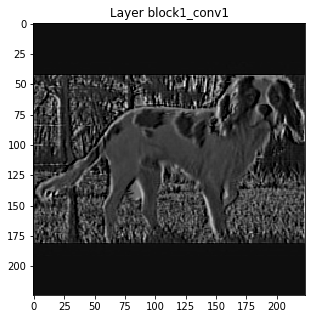

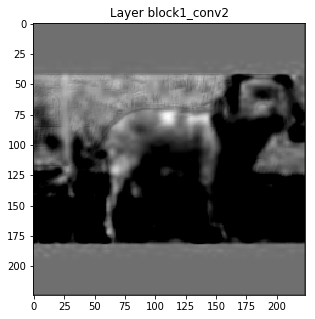

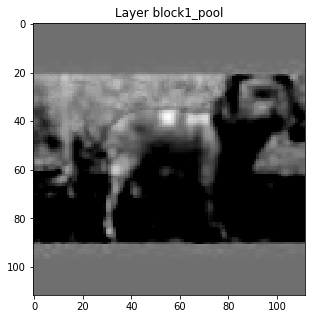

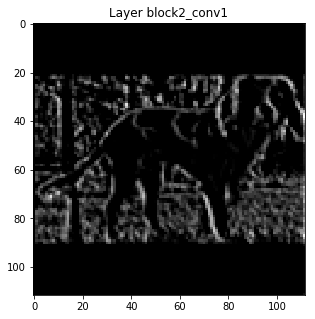

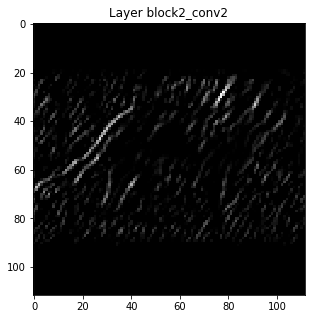

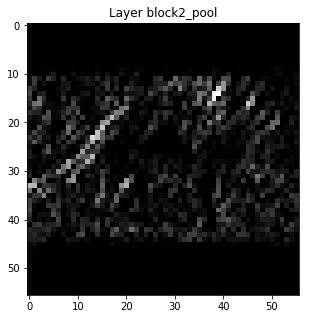

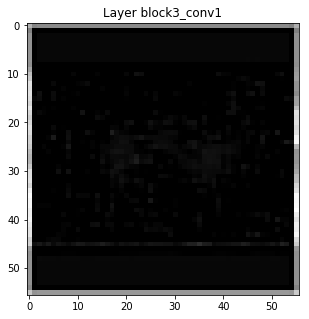

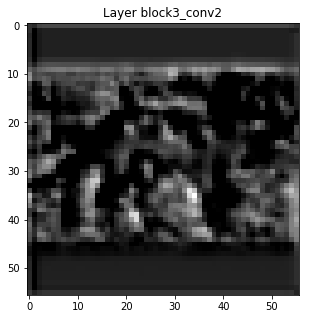

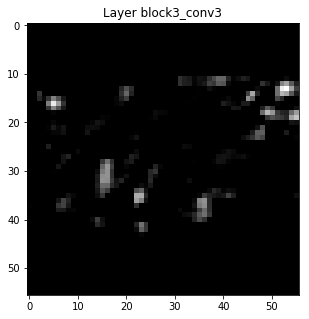

In [17]:
for layer in range(1,10):
    get_layer_output = K.function([model.layers[0].input],
                                  [model.layers[layer].output])
    layer_output =  get_layer_output([X_train[0].reshape(1,224,224,3)])[0]
    fig, ax = plt.subplots(figsize=(5,5))
    #fig.set_size_inches(18,7)
    res = np.squeeze(layer_output, axis=0)
    res.shape
    ax.set_title('Layer {}'.format(model.layers[layer].name))
    plt.imshow(res[:,:,2], cmap='gray')

## 2.2 Create bottleneck features

Let's extract bottleneck features from our model (VGG-16), especially the output without the last layer (fully connected)

In [18]:
# Reduce batch size to a limited batch_size
bottleneck_features_train = model.predict(X_train, batch_size=20)
bottleneck_features_validation = model.predict(X_valid, batch_size=20)

## 2.3 Train top model

Let's use this bottleneck features, and train a custom model on it:

In [20]:
model = Sequential()
model.add(Flatten(input_shape=bottleneck_features_train.shape[1:]))
model.add(Dense(num_class, activation='softmax'))
model.compile(optimizer=optimizers.SGD(lr=0.0001, momentum=0.9),
              loss='categorical_crossentropy', metrics=['accuracy'])
callbacks_list = [callbacks.EarlyStopping(monitor='val_acc', patience=3, verbose=1)]
history = model.fit(bottleneck_features_train, Y_train, 
              epochs=50,
              batch_size=20,
              validation_data=(bottleneck_features_validation, Y_valid), 
              verbose=1,
              callbacks=callbacks_list)

Train on 400 samples, validate on 100 samples
Epoch 1/50
400/400 [==============================] - 0s 418us/step - loss: 1.7941 - acc: 0.2425 - val_loss: 1.6485 - val_acc: 0.2300
Epoch 2/50
400/400 [==============================] - 0s 227us/step - loss: 1.3886 - acc: 0.4375 - val_loss: 1.3224 - val_acc: 0.4800
Epoch 3/50
400/400 [==============================] - 0s 220us/step - loss: 1.1193 - acc: 0.6200 - val_loss: 1.1454 - val_acc: 0.6300
Epoch 4/50
400/400 [==============================] - 0s 217us/step - loss: 0.9721 - acc: 0.7125 - val_loss: 1.0165 - val_acc: 0.6600
Epoch 5/50
400/400 [==============================] - 0s 220us/step - loss: 0.8350 - acc: 0.7825 - val_loss: 0.9303 - val_acc: 0.7300
Epoch 6/50
400/400 [==============================] - 0s 217us/step - loss: 0.7449 - acc: 0.7825 - val_loss: 0.8589 - val_acc: 0.7200
Epoch 7/50
400/400 [==============================] - 0s 242us/step - loss: 0.6687 - acc: 0.8400 - val_loss: 0.7863 - val_acc: 0.7400
Epoch 8/50
400/4

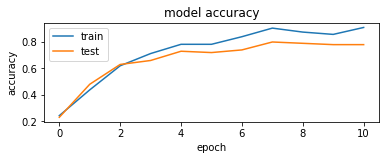

In [21]:
plt.subplot(211)
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

In [22]:
(eval_loss, eval_accuracy) = model.evaluate(
    bottleneck_features_validation, Y_valid, verbose=1)

print("[INFO] accuracy: {:.2f}%".format(eval_accuracy * 100))
print("[INFO] Loss: {}".format(eval_loss))

100/100 [==============================] - 0s 100us/step
[INFO] accuracy: 78.00%
[INFO] Loss: 0.6621413064002991


Not so bad, we can reach 76% of accuracy.

# 3. Adding Data Augmentation

In [23]:
train_data_dir = output_train_path
validation_data_dir = output_test_path
nb_train_samples = 80*5
nb_validation_samples = 20*5
epochs = 50
batch_size = 5

Let's define a specifc function **createDataGen** to create ImageDataGenerator object with parameter:
- shear_range
- zoom_range

In [24]:
def createDataGen():
    datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.1,
        zoom_range=0.1)
        #rotation_range=10)
        #horizontal_flip=True)
        #horizontal_flip=True,
        #vertical_flip=True)
        #featurewise_center=True,  # set input mean to 0 over the dataset
        #samplewise_center=True,  # set each sample mean to 0
        #featurewise_std_normalization=True)  # divide inputs by std of the dataset
        #samplewise_std_normalization=True)  # divide each input by its std
        #zca_whitening=True)  # apply ZCA whitening
        #rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        #width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        #height_shift_range=0.1)  # randomly shift images vertically (fraction of total height)
        #horizontal_flip=True,  # randomly flip images
        #vertical_flip=False)  # randomly flip images
    return datagen

The function **flow_from_dir** return ImageDataGenerator object to flow **batch_size** images per **epoch** iteration.

In [25]:
def flow_from_dir(datagen, path):
    return datagen.flow_from_directory(
                path,
                target_size=(224, 224),
                batch_size=batch_size,
                class_mode='categorical',
                shuffle=False)

## 3.1 Extract features of train dir

Let's reimport the VGG-16 model without the fully connected layer.

In [26]:
model = applications.VGG16(include_top=False, weights='imagenet', input_shape=(224, 224, 3))

We can also observe the output of Image Augmentation:

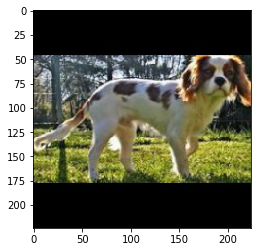

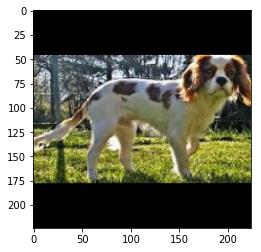

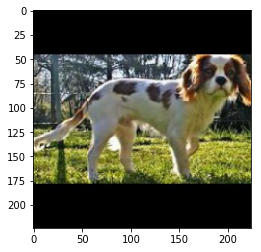

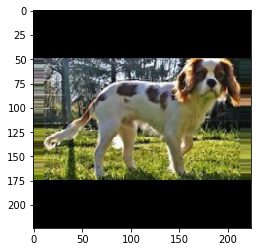

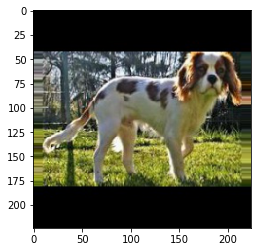

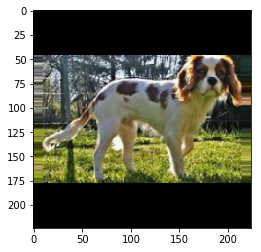

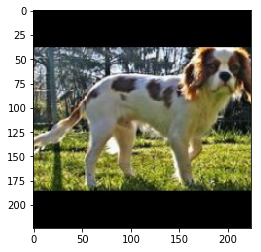

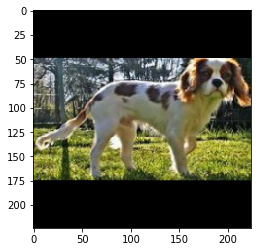

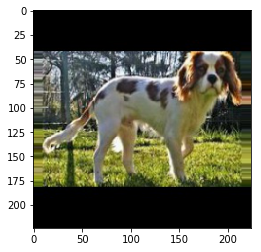

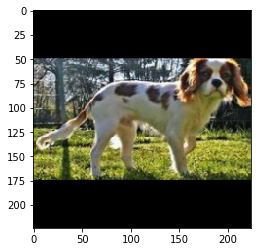

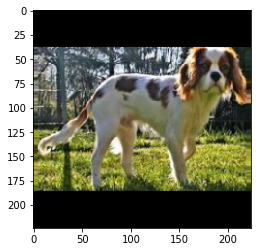

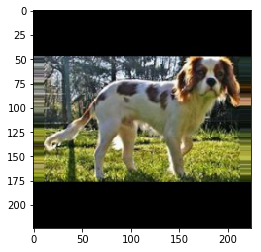

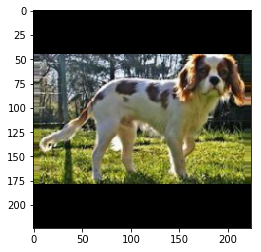

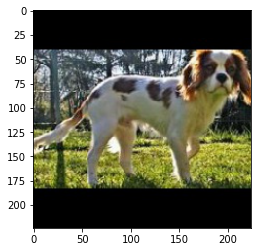

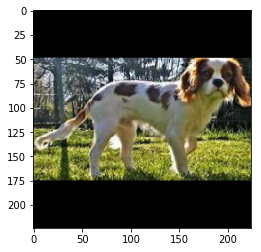

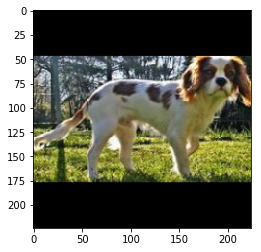

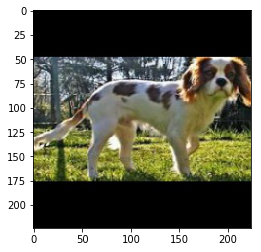

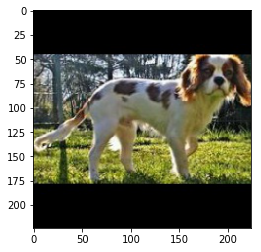

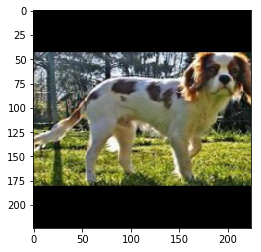

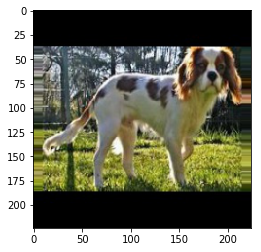

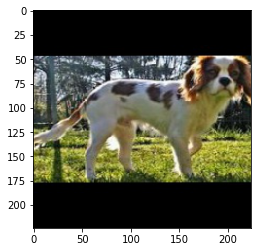

In [27]:
datagen = createDataGen()
img = load_img(output_train_path + os.sep + 'n02086646-Blenheim_spaniel/0.jpg')
x = img_to_array(img)
x = x.reshape((1,) + x.shape)
i = 0
for batch in datagen.flow(x, batch_size=1):
    i += 1
    new_image = array_to_img(batch[0])
    plt.imshow(new_image)
    plt.show()
    if i > 20:
        break  # otherwise the generator would loop indefinitely

In [28]:
datagen = createDataGen()
generator = flow_from_dir(datagen, train_data_dir)

Found 400 images belonging to 5 classes.


In [29]:
print(len(generator.filenames))
print(generator.class_indices)
print(len(generator.class_indices))

400
{'n02086646-Blenheim_spaniel': 0, 'n02088094-Afghan_hound': 1, 'n02093256-Staffordshire_bullterrier': 2, 'n02094114-Norfolk_terrier': 3, 'n02099712-Labrador_retriever': 4}
5


Let's build as previously our bottleneck features for train based on ImageAugmentation:

In [30]:
nb_train_samples = len(generator.filenames)
num_classes = len(generator.class_indices)
predict_size_train = int(math.ceil(nb_train_samples / batch_size))
train_data = model.predict_generator(generator, predict_size_train)
train_labels = generator.classes
train_labels = to_categorical(train_labels, num_classes=num_classes)

## 3.2 Extract features of validation dir

Let's also build bottleneck features for validation without ImageAugmentation:

In [31]:
# do not proceed dataaugmentation on validation dir
datagen = ImageDataGenerator(rescale=1./255)
generator = flow_from_dir(datagen, validation_data_dir)
nb_validation_samples = len(generator.filenames)
predict_size_validation = int(math.ceil(nb_validation_samples / batch_size))
validation_data = model.predict_generator(generator, predict_size_validation)
validation_labels = generator.classes
validation_labels = to_categorical(validation_labels, num_classes=num_classes)

Found 100 images belonging to 5 classes.


## 3.3 Train custom top model

Now we can train our model with the same fully connected layer:

In [32]:
model = Sequential()
model.add(Flatten(input_shape=train_data.shape[1:]))
model.add(Dense(num_class, activation='softmax'))
model.compile(optimizer=optimizers.SGD(lr=0.0001, momentum=0.9),
              loss='categorical_crossentropy', metrics=['accuracy'])

callbacks_list = [callbacks.EarlyStopping(monitor='val_acc', patience=3, verbose=1)]
history = model.fit(train_data, train_labels, 
              epochs=50,
              batch_size=batch_size,
              #validation_data=(bottleneck_features_validation, Y_valid),#(validation_data, validation_labels), 
              validation_data=(validation_data, validation_labels), 
              verbose=1,
              callbacks=callbacks_list)

Train on 400 samples, validate on 100 samples
Epoch 1/50
400/400 [==============================] - 1s 2ms/step - loss: 1.6009 - acc: 0.3350 - val_loss: 1.3973 - val_acc: 0.4200
Epoch 2/50
400/400 [==============================] - 0s 862us/step - loss: 1.1538 - acc: 0.5400 - val_loss: 1.0818 - val_acc: 0.6000
Epoch 3/50
400/400 [==============================] - 0s 825us/step - loss: 0.7475 - acc: 0.7625 - val_loss: 0.7350 - val_acc: 0.7500
Epoch 4/50
400/400 [==============================] - 0s 1ms/step - loss: 0.6454 - acc: 0.7950 - val_loss: 0.6675 - val_acc: 0.7700
Epoch 5/50
400/400 [==============================] - 0s 924us/step - loss: 0.4826 - acc: 0.8850 - val_loss: 0.7135 - val_acc: 0.7300
Epoch 6/50
400/400 [==============================] - 0s 855us/step - loss: 0.4731 - acc: 0.8650 - val_loss: 0.5762 - val_acc: 0.8200
Epoch 7/50
400/400 [==============================] - 0s 907us/step - loss: 0.4094 - acc: 0.8950 - val_loss: 0.6888 - val_acc: 0.7500
Epoch 8/50
400/400 [

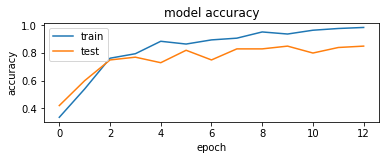

In [33]:
plt.subplot(211)
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

In [34]:
(eval_loss, eval_accuracy) = model.evaluate(
    #bottleneck_features_validation, Y_valid, batch_size=batch_size, verbose=1)
     validation_data, validation_labels, batch_size=batch_size, verbose=1)


print("[INFO] accuracy: {:.2f}%".format(eval_accuracy * 100))
print("[INFO] Loss: {}".format(eval_loss))

100/100 [==============================] - 0s 230us/step
[INFO] accuracy: 85.00%
[INFO] Loss: 0.4543743059039116


Nice, we improve of **3%** of accuracy, let's store our bottleneck features for cross validation.

In [35]:
np.save('train_data.npy', train_data)
np.save('train_labels.npy', train_labels)
np.save('validation_data.npy', validation_data)
np.save('validation_labels.npy', validation_labels)

# 4. Adding Cross Validation

In [6]:
train_data = np.load('train_data.npy')
train_labels = np.load('train_labels.npy')
validation_data = np.load('validation_data.npy')
validation_labels = np.load('validation_labels.npy')
num_classes=5

Let's define the **EstimatorSelectionHelper** class used for cross validation:

In [7]:
class EstimatorSelectionHelper:
    """
    Custom class for cross validation computation.
    It takes as parameters:
    - models and their associated parameters
    """
    def __init__(self, models, params):
        if not set(models.keys()).issubset(set(params.keys())):
            missing_params = list(set(models.keys()) - set(params.keys()))
            raise ValueError("Some estimators are missing parameters: %s" % missing_params)
        self.models = models
        self.params = params
        self.keys = models.keys()
        self.grid_searches = {}
    
    def fit(self, X, y, X_valid, y_valid, cv=5, n_jobs=1, verbose=1, scoring=None):
        for key in self.keys:
            print("Running GridSearchCV for %s." % key)
            model = self.models[key]
            params = self.params[key]
            #cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=1)
            cv = RepeatedKFold(n_splits=5, n_repeats=5)
            #cv = KFold(n_splits=5)
            gs = GridSearchCV(model, params, n_jobs=n_jobs, 
                              verbose=verbose, scoring=scoring, cv=cv)
            gs.fit(X, y, 
                   validation_data=(X_valid, y_valid),
                   callbacks=[callbacks.EarlyStopping(monitor='val_acc', patience=3, verbose=1)])
            self.grid_searches[key] = gs   
                
    def score_summary(self, sort_by='mean_score'):
        def row(key, train_score, test_score, std_test_score, params):
            d = {
                 'estimator': key,
                 'train_score': train_score,
                 'test_score': test_score,
                 'std_test_score': std_test_score * 2
            }
            d_copy = d.copy()
            d_copy.update(params)
            return pd.Series(d_copy)
                      
        rows = [row(k, train_score, test_score, std_test_score, params) 
                    for k in self.keys
                     for train_score, test_score, std_test_score, params 
                        in zip(self.grid_searches[k].cv_results_['mean_train_score'],
                               self.grid_searches[k].cv_results_['mean_test_score'], 
                               self.grid_searches[k].cv_results_['std_test_score'],
                               self.grid_searches[k].cv_results_['params'])]
        df = pd.concat(rows, axis=1).T#.sort([sort_by], ascending=False)
        
        columns = ['estimator', 'train_score', 'test_score', 'std_test_score']
        columns = columns + [c for c in df.columns if c not in columns]
        
        return df[columns]

Let's define the **plot_results** function to display confusion matrix based on results we have:

In [8]:
def plot_results(model, X_test, y_test):
    labels = ['n02086646-Blenheim_spaniel', 
              'n02088094-Afghan_hound', 
              'n02093256-Staffordshire_bullterrier',
              'n02094114-Norfolk_terrier',
              'n02099712-Labrador_retriever']
    y_pred = model.predict(X_test)
    y_true = np.argmax(y_test, axis=1)
    print("f1 score: ", f1_score(y_true, y_pred, average='micro'))
    predictions =  [labels[i] for i in y_pred]
    real = [labels[i] for i in y_true]
    cm = confusion_matrix(predictions, real)
    df_cm = pd.DataFrame(cm, index = labels,
                      columns = labels)
    sn.set(font_scale=1.4)#for label size
    sn.heatmap(df_cm, annot=True,annot_kws={"size": 16})

## 4.1 Optimizer selection

In [9]:
K.clear_session()

We will now optimize our fully connected layer based on:
- flatten
- dense
- dropout
- dense
- optimizer

In [10]:
def create_model1(dense, dropout, optimizer):
    model = Sequential()
    model.add(Flatten(input_shape=train_data.shape[1:]))
    model.add(Dense(dense, activation='relu'))
    model.add(Dropout(dropout))
    model.add(Dense(num_classes,
                    activation='softmax'))
    model.compile(optimizer=optimizer,
                  loss='categorical_crossentropy', metrics=['accuracy'])
    return model

Let's check which optimizer is the best between **SDG** and **ADAM** optimiser:

In [11]:
dense = [256]
dropout = [0.5]
epochs= [50]
batch_size = [5]
optimizer = ['SGD', 'Adam']
callbacks_= [callbacks.EarlyStopping(monitor='val_acc', patience=3, verbose=1)]
param_grid = dict(dense=dense, 
                  dropout=dropout, 
                  optimizer=optimizer,
                  epochs=epochs,
                  batch_size=batch_size,
                  callbacks=callbacks_)
model = KerasClassifier(build_fn=create_model1, verbose=0)

models = { 
    'MODEL': model
}

params = { 
    'MODEL': [param_grid]
}

helper = EstimatorSelectionHelper(models, params)
helper.fit(train_data, train_labels, validation_data, validation_labels, verbose=2)
res = helper.score_summary()
res

Running GridSearchCV for MODEL.
Fitting 25 folds for each of 2 candidates, totalling 50 fits
[CV] batch_size=5, callbacks=<keras.callbacks.EarlyStopping object at 0x0000026794BBE390>, dense=256, dropout=0.5, epochs=50, optimizer=SGD 
Epoch 00008: early stopping
[CV]  batch_size=5, callbacks=<keras.callbacks.EarlyStopping object at 0x0000026794BBE390>, dense=256, dropout=0.5, epochs=50, optimizer=SGD, total=  31.3s
[CV] batch_size=5, callbacks=<keras.callbacks.EarlyStopping object at 0x0000026794BBE390>, dense=256, dropout=0.5, epochs=50, optimizer=SGD 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   31.7s remaining:    0.0s


Epoch 00010: early stopping
[CV]  batch_size=5, callbacks=<keras.callbacks.EarlyStopping object at 0x0000026794BBE390>, dense=256, dropout=0.5, epochs=50, optimizer=SGD, total=  51.8s
[CV] batch_size=5, callbacks=<keras.callbacks.EarlyStopping object at 0x0000026794BBE390>, dense=256, dropout=0.5, epochs=50, optimizer=SGD 
Epoch 00007: early stopping
[CV]  batch_size=5, callbacks=<keras.callbacks.EarlyStopping object at 0x0000026794BBE390>, dense=256, dropout=0.5, epochs=50, optimizer=SGD, total=  42.2s
[CV] batch_size=5, callbacks=<keras.callbacks.EarlyStopping object at 0x0000026794BBE390>, dense=256, dropout=0.5, epochs=50, optimizer=SGD 
Epoch 00010: early stopping
[CV]  batch_size=5, callbacks=<keras.callbacks.EarlyStopping object at 0x0000026794BBE390>, dense=256, dropout=0.5, epochs=50, optimizer=SGD, total= 1.1min
[CV] batch_size=5, callbacks=<keras.callbacks.EarlyStopping object at 0x0000026794BBE390>, dense=256, dropout=0.5, epochs=50, optimizer=SGD 
Epoch 00010: early stoppi

Epoch 00010: early stopping
[CV]  batch_size=5, callbacks=<keras.callbacks.EarlyStopping object at 0x0000026794BBE390>, dense=256, dropout=0.5, epochs=50, optimizer=Adam, total= 2.6min
[CV] batch_size=5, callbacks=<keras.callbacks.EarlyStopping object at 0x0000026794BBE390>, dense=256, dropout=0.5, epochs=50, optimizer=Adam 
Epoch 00014: early stopping
[CV]  batch_size=5, callbacks=<keras.callbacks.EarlyStopping object at 0x0000026794BBE390>, dense=256, dropout=0.5, epochs=50, optimizer=Adam, total= 3.6min
[CV] batch_size=5, callbacks=<keras.callbacks.EarlyStopping object at 0x0000026794BBE390>, dense=256, dropout=0.5, epochs=50, optimizer=Adam 
Epoch 00011: early stopping
[CV]  batch_size=5, callbacks=<keras.callbacks.EarlyStopping object at 0x0000026794BBE390>, dense=256, dropout=0.5, epochs=50, optimizer=Adam, total= 2.9min
[CV] batch_size=5, callbacks=<keras.callbacks.EarlyStopping object at 0x0000026794BBE390>, dense=256, dropout=0.5, epochs=50, optimizer=Adam 
Epoch 00007: early 

[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed: 96.7min finished


Epoch 00008: early stopping


C:\Users\boisb\Anaconda3\envs\py36\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning: You are accessing a training score ('mean_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)


,estimator,train_score,test_score,std_test_score,batch_size,callbacks,dense,dropout,epochs,optimizer
0,MODEL,0.23375,0.196,0.105052,5,<keras.callbacks.EarlyStopping object at 0x000...,256,0.5,50,SGD
1,MODEL,0.95925,0.7285,0.245002,5,<keras.callbacks.EarlyStopping object at 0x000...,256,0.5,50,Adam


**Adam** optimiser gives the best score, let's optimize it!

## 4.2 Optimize Adam optimizer

### 4.2.1 Optimize batch_size

Let's first optimize the **batch_size** hyperparameter:

In [14]:
K.clear_session()

In [15]:
dense = [256]
dropout = [0.5]
epochs= [50]
batch_size = [5, 10, 20, 30, 40]
#optimizer = ['SGD', 'RMSprop', 'Adagrad', 'Adadelta', 'Adam', 'Adamax', 'Nadam']
optimizer = ['Adam']
callbacks_= [callbacks.EarlyStopping(monitor='val_acc', patience=3, verbose=1)]
param_grid = dict(dense=dense, 
                  dropout=dropout, 
                  optimizer=optimizer,
                  epochs=epochs,
                  batch_size=batch_size,
                  callbacks=callbacks_)
model = KerasClassifier(build_fn=create_model1, verbose=0)

models = { 
    'MODEL': model
}

params = { 
    'MODEL': [param_grid]
}

helper = EstimatorSelectionHelper(models, params)
helper.fit(train_data, train_labels, validation_data, validation_labels, verbose=2)
res = helper.score_summary()
res

Running GridSearchCV for MODEL.
Fitting 25 folds for each of 5 candidates, totalling 125 fits
[CV] batch_size=5, callbacks=<keras.callbacks.EarlyStopping object at 0x00000267801D4FD0>, dense=256, dropout=0.5, epochs=50, optimizer=Adam 
Epoch 00008: early stopping
[CV]  batch_size=5, callbacks=<keras.callbacks.EarlyStopping object at 0x00000267801D4FD0>, dense=256, dropout=0.5, epochs=50, optimizer=Adam, total= 1.3min
[CV] batch_size=5, callbacks=<keras.callbacks.EarlyStopping object at 0x00000267801D4FD0>, dense=256, dropout=0.5, epochs=50, optimizer=Adam 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.3min remaining:    0.0s


Epoch 00006: early stopping
[CV]  batch_size=5, callbacks=<keras.callbacks.EarlyStopping object at 0x00000267801D4FD0>, dense=256, dropout=0.5, epochs=50, optimizer=Adam, total= 1.2min
[CV] batch_size=5, callbacks=<keras.callbacks.EarlyStopping object at 0x00000267801D4FD0>, dense=256, dropout=0.5, epochs=50, optimizer=Adam 
Epoch 00014: early stopping
[CV]  batch_size=5, callbacks=<keras.callbacks.EarlyStopping object at 0x00000267801D4FD0>, dense=256, dropout=0.5, epochs=50, optimizer=Adam, total= 3.5min
[CV] batch_size=5, callbacks=<keras.callbacks.EarlyStopping object at 0x00000267801D4FD0>, dense=256, dropout=0.5, epochs=50, optimizer=Adam 
Epoch 00011: early stopping
[CV]  batch_size=5, callbacks=<keras.callbacks.EarlyStopping object at 0x00000267801D4FD0>, dense=256, dropout=0.5, epochs=50, optimizer=Adam, total= 2.8min
[CV] batch_size=5, callbacks=<keras.callbacks.EarlyStopping object at 0x00000267801D4FD0>, dense=256, dropout=0.5, epochs=50, optimizer=Adam 
Epoch 00009: early 

[CV]  batch_size=10, callbacks=<keras.callbacks.EarlyStopping object at 0x00000267801D4FD0>, dense=256, dropout=0.5, epochs=50, optimizer=Adam, total=  47.5s
[CV] batch_size=10, callbacks=<keras.callbacks.EarlyStopping object at 0x00000267801D4FD0>, dense=256, dropout=0.5, epochs=50, optimizer=Adam 
Epoch 00011: early stopping
[CV]  batch_size=10, callbacks=<keras.callbacks.EarlyStopping object at 0x00000267801D4FD0>, dense=256, dropout=0.5, epochs=50, optimizer=Adam, total= 1.4min
[CV] batch_size=10, callbacks=<keras.callbacks.EarlyStopping object at 0x00000267801D4FD0>, dense=256, dropout=0.5, epochs=50, optimizer=Adam 
Epoch 00013: early stopping
[CV]  batch_size=10, callbacks=<keras.callbacks.EarlyStopping object at 0x00000267801D4FD0>, dense=256, dropout=0.5, epochs=50, optimizer=Adam, total= 1.7min
[CV] batch_size=10, callbacks=<keras.callbacks.EarlyStopping object at 0x00000267801D4FD0>, dense=256, dropout=0.5, epochs=50, optimizer=Adam 
Epoch 00008: early stopping
[CV]  batch_s

Epoch 00009: early stopping
[CV]  batch_size=20, callbacks=<keras.callbacks.EarlyStopping object at 0x00000267801D4FD0>, dense=256, dropout=0.5, epochs=50, optimizer=Adam, total=  40.8s
[CV] batch_size=20, callbacks=<keras.callbacks.EarlyStopping object at 0x00000267801D4FD0>, dense=256, dropout=0.5, epochs=50, optimizer=Adam 
Epoch 00012: early stopping
[CV]  batch_size=20, callbacks=<keras.callbacks.EarlyStopping object at 0x00000267801D4FD0>, dense=256, dropout=0.5, epochs=50, optimizer=Adam, total=  56.5s
[CV] batch_size=20, callbacks=<keras.callbacks.EarlyStopping object at 0x00000267801D4FD0>, dense=256, dropout=0.5, epochs=50, optimizer=Adam 
Epoch 00008: early stopping
[CV]  batch_size=20, callbacks=<keras.callbacks.EarlyStopping object at 0x00000267801D4FD0>, dense=256, dropout=0.5, epochs=50, optimizer=Adam, total=  39.2s
[CV] batch_size=20, callbacks=<keras.callbacks.EarlyStopping object at 0x00000267801D4FD0>, dense=256, dropout=0.5, epochs=50, optimizer=Adam 
Epoch 00011: 

Epoch 00012: early stopping
[CV]  batch_size=30, callbacks=<keras.callbacks.EarlyStopping object at 0x00000267801D4FD0>, dense=256, dropout=0.5, epochs=50, optimizer=Adam, total=  36.9s
[CV] batch_size=30, callbacks=<keras.callbacks.EarlyStopping object at 0x00000267801D4FD0>, dense=256, dropout=0.5, epochs=50, optimizer=Adam 
Epoch 00011: early stopping
[CV]  batch_size=30, callbacks=<keras.callbacks.EarlyStopping object at 0x00000267801D4FD0>, dense=256, dropout=0.5, epochs=50, optimizer=Adam, total=  36.8s
[CV] batch_size=30, callbacks=<keras.callbacks.EarlyStopping object at 0x00000267801D4FD0>, dense=256, dropout=0.5, epochs=50, optimizer=Adam 
Epoch 00018: early stopping
[CV]  batch_size=30, callbacks=<keras.callbacks.EarlyStopping object at 0x00000267801D4FD0>, dense=256, dropout=0.5, epochs=50, optimizer=Adam, total=  54.9s
[CV] batch_size=30, callbacks=<keras.callbacks.EarlyStopping object at 0x00000267801D4FD0>, dense=256, dropout=0.5, epochs=50, optimizer=Adam 
Epoch 00013: 

Epoch 00011: early stopping
[CV]  batch_size=40, callbacks=<keras.callbacks.EarlyStopping object at 0x00000267801D4FD0>, dense=256, dropout=0.5, epochs=50, optimizer=Adam, total=  28.8s
[CV] batch_size=40, callbacks=<keras.callbacks.EarlyStopping object at 0x00000267801D4FD0>, dense=256, dropout=0.5, epochs=50, optimizer=Adam 
Epoch 00012: early stopping
[CV]  batch_size=40, callbacks=<keras.callbacks.EarlyStopping object at 0x00000267801D4FD0>, dense=256, dropout=0.5, epochs=50, optimizer=Adam, total=  32.4s
[CV] batch_size=40, callbacks=<keras.callbacks.EarlyStopping object at 0x00000267801D4FD0>, dense=256, dropout=0.5, epochs=50, optimizer=Adam 
Epoch 00014: early stopping
[CV]  batch_size=40, callbacks=<keras.callbacks.EarlyStopping object at 0x00000267801D4FD0>, dense=256, dropout=0.5, epochs=50, optimizer=Adam, total=  36.1s
[CV] batch_size=40, callbacks=<keras.callbacks.EarlyStopping object at 0x00000267801D4FD0>, dense=256, dropout=0.5, epochs=50, optimizer=Adam 
Epoch 00011: 

[Parallel(n_jobs=1)]: Done 125 out of 125 | elapsed: 152.2min finished


Epoch 00012: early stopping


C:\Users\boisb\Anaconda3\envs\py36\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning: You are accessing a training score ('mean_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)


,estimator,train_score,test_score,std_test_score,batch_size,callbacks,dense,dropout,epochs,optimizer
0,MODEL,0.988625,0.7465,0.0993781,5,<keras.callbacks.EarlyStopping object at 0x000...,256,0.5,50,Adam
1,MODEL,0.994625,0.7705,0.0994686,10,<keras.callbacks.EarlyStopping object at 0x000...,256,0.5,50,Adam
2,MODEL,0.998625,0.7955,0.10022,20,<keras.callbacks.EarlyStopping object at 0x000...,256,0.5,50,Adam
3,MODEL,0.999375,0.7905,0.075921,30,<keras.callbacks.EarlyStopping object at 0x000...,256,0.5,50,Adam
4,MODEL,0.9855,0.7775,0.153623,40,<keras.callbacks.EarlyStopping object at 0x000...,256,0.5,50,Adam


### 4.2.2 Optimize learning rate

After having optimize **batch_size**, let's optimize **learning rate** hyperparameter for **ADAM** optimizer:

In [16]:
K.clear_session()

In [17]:
def create_model(dense, dropout, lr, beta_1, beta_2, epsilon, decay):
    model = Sequential()
    model.add(Flatten(input_shape=train_data.shape[1:]))
    model.add(Dense(dense, activation='relu'))
    model.add(Dropout(dropout))
    model.add(Dense(num_classes,
                    #kernel_regularizer=regularizers.l2(0.01),
                    #activity_regularizer=regularizers.l1(0.01),
                    activation='softmax'))
    optimizer = optimizers.Adam(lr=lr, beta_1=beta_1, beta_2=beta_2, epsilon=epsilon, decay=decay)
    model.compile(optimizer=optimizer,
                  loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [18]:
lr = [0.0001, 0.001, 0.01, 0.1]
beta_1 = [0.9]#[0.6,0.7,0.8,0.9]
beta_2 = [0.999]
epsilon = [None]
decay = [0.0]
dense = [256]
dropout = [0.5]
epochs= [50]
batch_size = [40]
callbacks_= [callbacks.EarlyStopping(monitor='val_acc', patience=3, verbose=1)]
param_grid = dict(dense=dense, 
                  dropout=dropout, 
                  lr=lr, 
                  beta_1=beta_1,
                  beta_2=beta_2,
                  epsilon=epsilon,
                  decay=decay,
                  epochs=epochs,
                  batch_size=batch_size,
                  callbacks=callbacks_)
model = KerasClassifier(build_fn=create_model, verbose=0)

models = { 
    'MODEL': model
}

params = { 
    'MODEL': [param_grid]
}

helper = EstimatorSelectionHelper(models, params)
helper.fit(train_data, train_labels, validation_data, validation_labels, verbose=2)
res = helper.score_summary()
res

Running GridSearchCV for MODEL.
Fitting 25 folds for each of 4 candidates, totalling 100 fits
[CV] batch_size=40, beta_1=0.9, beta_2=0.999, callbacks=<keras.callbacks.EarlyStopping object at 0x00000267813B77B8>, decay=0.0, dense=256, dropout=0.5, epochs=50, epsilon=None, lr=0.0001 
Epoch 00007: early stopping
[CV]  batch_size=40, beta_1=0.9, beta_2=0.999, callbacks=<keras.callbacks.EarlyStopping object at 0x00000267813B77B8>, decay=0.0, dense=256, dropout=0.5, epochs=50, epsilon=None, lr=0.0001, total=  15.6s
[CV] batch_size=40, beta_1=0.9, beta_2=0.999, callbacks=<keras.callbacks.EarlyStopping object at 0x00000267813B77B8>, decay=0.0, dense=256, dropout=0.5, epochs=50, epsilon=None, lr=0.0001 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   15.9s remaining:    0.0s


Epoch 00007: early stopping
[CV]  batch_size=40, beta_1=0.9, beta_2=0.999, callbacks=<keras.callbacks.EarlyStopping object at 0x00000267813B77B8>, decay=0.0, dense=256, dropout=0.5, epochs=50, epsilon=None, lr=0.0001, total=  17.3s
[CV] batch_size=40, beta_1=0.9, beta_2=0.999, callbacks=<keras.callbacks.EarlyStopping object at 0x00000267813B77B8>, decay=0.0, dense=256, dropout=0.5, epochs=50, epsilon=None, lr=0.0001 
Epoch 00011: early stopping
[CV]  batch_size=40, beta_1=0.9, beta_2=0.999, callbacks=<keras.callbacks.EarlyStopping object at 0x00000267813B77B8>, decay=0.0, dense=256, dropout=0.5, epochs=50, epsilon=None, lr=0.0001, total=  26.4s
[CV] batch_size=40, beta_1=0.9, beta_2=0.999, callbacks=<keras.callbacks.EarlyStopping object at 0x00000267813B77B8>, decay=0.0, dense=256, dropout=0.5, epochs=50, epsilon=None, lr=0.0001 
Epoch 00014: early stopping
[CV]  batch_size=40, beta_1=0.9, beta_2=0.999, callbacks=<keras.callbacks.EarlyStopping object at 0x00000267813B77B8>, decay=0.0, 

Epoch 00010: early stopping
[CV]  batch_size=40, beta_1=0.9, beta_2=0.999, callbacks=<keras.callbacks.EarlyStopping object at 0x00000267813B77B8>, decay=0.0, dense=256, dropout=0.5, epochs=50, epsilon=None, lr=0.0001, total=  24.0s
[CV] batch_size=40, beta_1=0.9, beta_2=0.999, callbacks=<keras.callbacks.EarlyStopping object at 0x00000267813B77B8>, decay=0.0, dense=256, dropout=0.5, epochs=50, epsilon=None, lr=0.0001 
Epoch 00012: early stopping
[CV]  batch_size=40, beta_1=0.9, beta_2=0.999, callbacks=<keras.callbacks.EarlyStopping object at 0x00000267813B77B8>, decay=0.0, dense=256, dropout=0.5, epochs=50, epsilon=None, lr=0.0001, total=  28.3s
[CV] batch_size=40, beta_1=0.9, beta_2=0.999, callbacks=<keras.callbacks.EarlyStopping object at 0x00000267813B77B8>, decay=0.0, dense=256, dropout=0.5, epochs=50, epsilon=None, lr=0.0001 
Epoch 00012: early stopping
[CV]  batch_size=40, beta_1=0.9, beta_2=0.999, callbacks=<keras.callbacks.EarlyStopping object at 0x00000267813B77B8>, decay=0.0, 

Epoch 00017: early stopping
[CV]  batch_size=40, beta_1=0.9, beta_2=0.999, callbacks=<keras.callbacks.EarlyStopping object at 0x00000267813B77B8>, decay=0.0, dense=256, dropout=0.5, epochs=50, epsilon=None, lr=0.001, total=  40.5s
[CV] batch_size=40, beta_1=0.9, beta_2=0.999, callbacks=<keras.callbacks.EarlyStopping object at 0x00000267813B77B8>, decay=0.0, dense=256, dropout=0.5, epochs=50, epsilon=None, lr=0.001 
Epoch 00015: early stopping
[CV]  batch_size=40, beta_1=0.9, beta_2=0.999, callbacks=<keras.callbacks.EarlyStopping object at 0x00000267813B77B8>, decay=0.0, dense=256, dropout=0.5, epochs=50, epsilon=None, lr=0.001, total=  35.3s
[CV] batch_size=40, beta_1=0.9, beta_2=0.999, callbacks=<keras.callbacks.EarlyStopping object at 0x00000267813B77B8>, decay=0.0, dense=256, dropout=0.5, epochs=50, epsilon=None, lr=0.001 
Epoch 00016: early stopping
[CV]  batch_size=40, beta_1=0.9, beta_2=0.999, callbacks=<keras.callbacks.EarlyStopping object at 0x00000267813B77B8>, decay=0.0, dens

Epoch 00004: early stopping
[CV]  batch_size=40, beta_1=0.9, beta_2=0.999, callbacks=<keras.callbacks.EarlyStopping object at 0x00000267813B77B8>, decay=0.0, dense=256, dropout=0.5, epochs=50, epsilon=None, lr=0.01, total=  12.6s
[CV] batch_size=40, beta_1=0.9, beta_2=0.999, callbacks=<keras.callbacks.EarlyStopping object at 0x00000267813B77B8>, decay=0.0, dense=256, dropout=0.5, epochs=50, epsilon=None, lr=0.01 
Epoch 00004: early stopping
[CV]  batch_size=40, beta_1=0.9, beta_2=0.999, callbacks=<keras.callbacks.EarlyStopping object at 0x00000267813B77B8>, decay=0.0, dense=256, dropout=0.5, epochs=50, epsilon=None, lr=0.01, total=  12.7s
[CV] batch_size=40, beta_1=0.9, beta_2=0.999, callbacks=<keras.callbacks.EarlyStopping object at 0x00000267813B77B8>, decay=0.0, dense=256, dropout=0.5, epochs=50, epsilon=None, lr=0.01 
Epoch 00004: early stopping
[CV]  batch_size=40, beta_1=0.9, beta_2=0.999, callbacks=<keras.callbacks.EarlyStopping object at 0x00000267813B77B8>, decay=0.0, dense=25

Epoch 00004: early stopping
[CV]  batch_size=40, beta_1=0.9, beta_2=0.999, callbacks=<keras.callbacks.EarlyStopping object at 0x00000267813B77B8>, decay=0.0, dense=256, dropout=0.5, epochs=50, epsilon=None, lr=0.1, total=  12.6s
[CV] batch_size=40, beta_1=0.9, beta_2=0.999, callbacks=<keras.callbacks.EarlyStopping object at 0x00000267813B77B8>, decay=0.0, dense=256, dropout=0.5, epochs=50, epsilon=None, lr=0.1 
Epoch 00004: early stopping
[CV]  batch_size=40, beta_1=0.9, beta_2=0.999, callbacks=<keras.callbacks.EarlyStopping object at 0x00000267813B77B8>, decay=0.0, dense=256, dropout=0.5, epochs=50, epsilon=None, lr=0.1, total=  12.3s
[CV] batch_size=40, beta_1=0.9, beta_2=0.999, callbacks=<keras.callbacks.EarlyStopping object at 0x00000267813B77B8>, decay=0.0, dense=256, dropout=0.5, epochs=50, epsilon=None, lr=0.1 
Epoch 00004: early stopping
[CV]  batch_size=40, beta_1=0.9, beta_2=0.999, callbacks=<keras.callbacks.EarlyStopping object at 0x00000267813B77B8>, decay=0.0, dense=256, d

[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed: 34.9min finished


Epoch 00011: early stopping


C:\Users\boisb\Anaconda3\envs\py36\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning: You are accessing a training score ('mean_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)


,estimator,train_score,test_score,std_test_score,batch_size,beta_1,beta_2,callbacks,decay,dense,dropout,epochs,epsilon,lr
0,MODEL,0.9985,0.786,0.0701142,40,0.9,0.999,<keras.callbacks.EarlyStopping object at 0x000...,0,256,0.5,50,None,0.0001
1,MODEL,0.99775,0.7855,0.0737157,40,0.9,0.999,<keras.callbacks.EarlyStopping object at 0x000...,0,256,0.5,50,None,0.001
2,MODEL,0.201125,0.2005,0.069455,40,0.9,0.999,<keras.callbacks.EarlyStopping object at 0x000...,0,256,0.5,50,None,0.01
3,MODEL,0.204375,0.1825,0.072111,40,0.9,0.999,<keras.callbacks.EarlyStopping object at 0x000...,0,256,0.5,50,None,0.1


In [19]:
helper.grid_searches['MODEL'].best_params_

{'batch_size': 40,
 'beta_1': 0.9,
 'beta_2': 0.999,
 'callbacks': <keras.callbacks.EarlyStopping at 0x267813b77b8>,
 'decay': 0.0,
 'dense': 256,
 'dropout': 0.5,
 'epochs': 50,
 'epsilon': None,
 'lr': 0.0001}

f1 score:  0.83


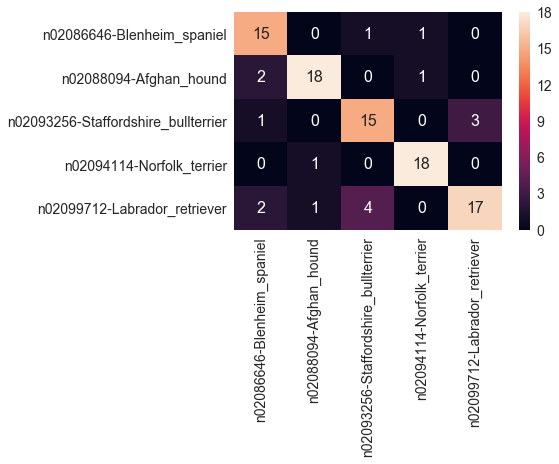

In [20]:
plot_results(helper.grid_searches['MODEL'].best_estimator_, validation_data, validation_labels)

In [21]:
K.clear_session()
model = create_model(256, 0.5, 0.0001, 0.9, 0.999, None, 0.0)
callbacks_= [callbacks.EarlyStopping(monitor='val_acc', patience=3, verbose=1)]
history = model.fit(train_data,
                   train_labels,
                   epochs=50,
                   batch_size=40,
                   validation_data=(validation_data, validation_labels),
                   callbacks=callbacks_)

Train on 400 samples, validate on 100 samples
Epoch 1/50
400/400 [==============================] - 3s 8ms/step - loss: 1.8534 - acc: 0.2600 - val_loss: 1.2951 - val_acc: 0.4800
Epoch 2/50
400/400 [==============================] - 3s 7ms/step - loss: 1.1504 - acc: 0.5750 - val_loss: 1.0108 - val_acc: 0.6800
Epoch 3/50
400/400 [==============================] - 3s 7ms/step - loss: 0.7918 - acc: 0.7200 - val_loss: 0.7679 - val_acc: 0.6900
Epoch 4/50
400/400 [==============================] - 3s 8ms/step - loss: 0.5660 - acc: 0.8200 - val_loss: 0.6705 - val_acc: 0.7100
Epoch 5/50
400/400 [==============================] - 3s 7ms/step - loss: 0.4479 - acc: 0.8600 - val_loss: 0.5145 - val_acc: 0.8500
Epoch 6/50
400/400 [==============================] - 3s 8ms/step - loss: 0.3106 - acc: 0.9250 - val_loss: 0.4674 - val_acc: 0.8400
Epoch 7/50
400/400 [==============================] - 3s 7ms/step - loss: 0.2576 - acc: 0.9600 - val_loss: 0.4427 - val_acc: 0.8700
Epoch 8/50
400/400 [==========

In [22]:
(eval_loss, eval_accuracy) = model.evaluate(
    #bottleneck_features_validation, Y_valid, batch_size=batch_size, verbose=1)
     validation_data, validation_labels, batch_size=40, verbose=1)


print("[INFO] accuracy: {:.2f}%".format(eval_accuracy * 100))
print("[INFO] Loss: {}".format(eval_loss))

100/100 [==============================] - 0s 1ms/step
[INFO] accuracy: 88.00%
[INFO] Loss: 0.3435747385025024


In [23]:
top_model_weights_path = 'fc_model_adam_1.h5'
model.save_weights(top_model_weights_path)

Good news, we improve our previous model from **2%**!

### 4.2.3 Optimize dense+droupout

Let's play now with **dense** and **dropout** hyperparameters:

In [24]:
K.clear_session()

In [25]:
lr = [0.0001]
beta_1 = [0.9]
beta_2 = [0.999]
epsilon = [None]
decay = [0.0]
dense = [128, 256]
dropout = [0.4, 0.5, 0.6]
epochs= [50]
batch_size = [40]
callbacks_= [callbacks.EarlyStopping(monitor='val_acc', patience=3, verbose=1)]
param_grid = dict(dense=dense, 
                  dropout=dropout, 
                  lr=lr, 
                  beta_1=beta_1,
                  beta_2=beta_2,
                  epsilon=epsilon,
                  decay=decay,
                  epochs=epochs,
                  batch_size=batch_size,
                  callbacks=callbacks_)
model = KerasClassifier(build_fn=create_model, verbose=0)

models = { 
    'MODEL': model
}

params = { 
    'MODEL': [param_grid]
}

helper = EstimatorSelectionHelper(models, params)
helper.fit(train_data, train_labels, validation_data, validation_labels, verbose=2)
res = helper.score_summary()
res

Running GridSearchCV for MODEL.
Fitting 25 folds for each of 6 candidates, totalling 150 fits
[CV] batch_size=40, beta_1=0.9, beta_2=0.999, callbacks=<keras.callbacks.EarlyStopping object at 0x00000267A355EE10>, decay=0.0, dense=128, dropout=0.4, epochs=50, epsilon=None, lr=0.0001 
Epoch 00010: early stopping
[CV]  batch_size=40, beta_1=0.9, beta_2=0.999, callbacks=<keras.callbacks.EarlyStopping object at 0x00000267A355EE10>, decay=0.0, dense=128, dropout=0.4, epochs=50, epsilon=None, lr=0.0001, total=   5.6s
[CV] batch_size=40, beta_1=0.9, beta_2=0.999, callbacks=<keras.callbacks.EarlyStopping object at 0x00000267A355EE10>, decay=0.0, dense=128, dropout=0.4, epochs=50, epsilon=None, lr=0.0001 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    5.7s remaining:    0.0s


Epoch 00017: early stopping
[CV]  batch_size=40, beta_1=0.9, beta_2=0.999, callbacks=<keras.callbacks.EarlyStopping object at 0x00000267A355EE10>, decay=0.0, dense=128, dropout=0.4, epochs=50, epsilon=None, lr=0.0001, total=   9.6s
[CV] batch_size=40, beta_1=0.9, beta_2=0.999, callbacks=<keras.callbacks.EarlyStopping object at 0x00000267A355EE10>, decay=0.0, dense=128, dropout=0.4, epochs=50, epsilon=None, lr=0.0001 
Epoch 00009: early stopping
[CV]  batch_size=40, beta_1=0.9, beta_2=0.999, callbacks=<keras.callbacks.EarlyStopping object at 0x00000267A355EE10>, decay=0.0, dense=128, dropout=0.4, epochs=50, epsilon=None, lr=0.0001, total=   6.2s
[CV] batch_size=40, beta_1=0.9, beta_2=0.999, callbacks=<keras.callbacks.EarlyStopping object at 0x00000267A355EE10>, decay=0.0, dense=128, dropout=0.4, epochs=50, epsilon=None, lr=0.0001 
Epoch 00016: early stopping
[CV]  batch_size=40, beta_1=0.9, beta_2=0.999, callbacks=<keras.callbacks.EarlyStopping object at 0x00000267A355EE10>, decay=0.0, 

Epoch 00016: early stopping
[CV]  batch_size=40, beta_1=0.9, beta_2=0.999, callbacks=<keras.callbacks.EarlyStopping object at 0x00000267A355EE10>, decay=0.0, dense=128, dropout=0.4, epochs=50, epsilon=None, lr=0.0001, total=  22.9s
[CV] batch_size=40, beta_1=0.9, beta_2=0.999, callbacks=<keras.callbacks.EarlyStopping object at 0x00000267A355EE10>, decay=0.0, dense=128, dropout=0.4, epochs=50, epsilon=None, lr=0.0001 
Epoch 00014: early stopping
[CV]  batch_size=40, beta_1=0.9, beta_2=0.999, callbacks=<keras.callbacks.EarlyStopping object at 0x00000267A355EE10>, decay=0.0, dense=128, dropout=0.4, epochs=50, epsilon=None, lr=0.0001, total=  18.5s
[CV] batch_size=40, beta_1=0.9, beta_2=0.999, callbacks=<keras.callbacks.EarlyStopping object at 0x00000267A355EE10>, decay=0.0, dense=128, dropout=0.4, epochs=50, epsilon=None, lr=0.0001 
Epoch 00011: early stopping
[CV]  batch_size=40, beta_1=0.9, beta_2=0.999, callbacks=<keras.callbacks.EarlyStopping object at 0x00000267A355EE10>, decay=0.0, 

Epoch 00017: early stopping
[CV]  batch_size=40, beta_1=0.9, beta_2=0.999, callbacks=<keras.callbacks.EarlyStopping object at 0x00000267A355EE10>, decay=0.0, dense=128, dropout=0.5, epochs=50, epsilon=None, lr=0.0001, total=  26.5s
[CV] batch_size=40, beta_1=0.9, beta_2=0.999, callbacks=<keras.callbacks.EarlyStopping object at 0x00000267A355EE10>, decay=0.0, dense=128, dropout=0.5, epochs=50, epsilon=None, lr=0.0001 
Epoch 00010: early stopping
[CV]  batch_size=40, beta_1=0.9, beta_2=0.999, callbacks=<keras.callbacks.EarlyStopping object at 0x00000267A355EE10>, decay=0.0, dense=128, dropout=0.5, epochs=50, epsilon=None, lr=0.0001, total=  17.4s
[CV] batch_size=40, beta_1=0.9, beta_2=0.999, callbacks=<keras.callbacks.EarlyStopping object at 0x00000267A355EE10>, decay=0.0, dense=128, dropout=0.5, epochs=50, epsilon=None, lr=0.0001 
Epoch 00020: early stopping
[CV]  batch_size=40, beta_1=0.9, beta_2=0.999, callbacks=<keras.callbacks.EarlyStopping object at 0x00000267A355EE10>, decay=0.0, 

Epoch 00009: early stopping
[CV]  batch_size=40, beta_1=0.9, beta_2=0.999, callbacks=<keras.callbacks.EarlyStopping object at 0x00000267A355EE10>, decay=0.0, dense=128, dropout=0.6, epochs=50, epsilon=None, lr=0.0001, total=  14.6s
[CV] batch_size=40, beta_1=0.9, beta_2=0.999, callbacks=<keras.callbacks.EarlyStopping object at 0x00000267A355EE10>, decay=0.0, dense=128, dropout=0.6, epochs=50, epsilon=None, lr=0.0001 
Epoch 00012: early stopping
[CV]  batch_size=40, beta_1=0.9, beta_2=0.999, callbacks=<keras.callbacks.EarlyStopping object at 0x00000267A355EE10>, decay=0.0, dense=128, dropout=0.6, epochs=50, epsilon=None, lr=0.0001, total=  18.9s
[CV] batch_size=40, beta_1=0.9, beta_2=0.999, callbacks=<keras.callbacks.EarlyStopping object at 0x00000267A355EE10>, decay=0.0, dense=128, dropout=0.6, epochs=50, epsilon=None, lr=0.0001 
Epoch 00021: early stopping
[CV]  batch_size=40, beta_1=0.9, beta_2=0.999, callbacks=<keras.callbacks.EarlyStopping object at 0x00000267A355EE10>, decay=0.0, 

Epoch 00011: early stopping
[CV]  batch_size=40, beta_1=0.9, beta_2=0.999, callbacks=<keras.callbacks.EarlyStopping object at 0x00000267A355EE10>, decay=0.0, dense=256, dropout=0.4, epochs=50, epsilon=None, lr=0.0001, total=  31.5s
[CV] batch_size=40, beta_1=0.9, beta_2=0.999, callbacks=<keras.callbacks.EarlyStopping object at 0x00000267A355EE10>, decay=0.0, dense=256, dropout=0.4, epochs=50, epsilon=None, lr=0.0001 
Epoch 00008: early stopping
[CV]  batch_size=40, beta_1=0.9, beta_2=0.999, callbacks=<keras.callbacks.EarlyStopping object at 0x00000267A355EE10>, decay=0.0, dense=256, dropout=0.4, epochs=50, epsilon=None, lr=0.0001, total=  25.1s
[CV] batch_size=40, beta_1=0.9, beta_2=0.999, callbacks=<keras.callbacks.EarlyStopping object at 0x00000267A355EE10>, decay=0.0, dense=256, dropout=0.4, epochs=50, epsilon=None, lr=0.0001 
Epoch 00010: early stopping
[CV]  batch_size=40, beta_1=0.9, beta_2=0.999, callbacks=<keras.callbacks.EarlyStopping object at 0x00000267A355EE10>, decay=0.0, 

Epoch 00012: early stopping
[CV]  batch_size=40, beta_1=0.9, beta_2=0.999, callbacks=<keras.callbacks.EarlyStopping object at 0x00000267A355EE10>, decay=0.0, dense=256, dropout=0.5, epochs=50, epsilon=None, lr=0.0001, total=  41.8s
[CV] batch_size=40, beta_1=0.9, beta_2=0.999, callbacks=<keras.callbacks.EarlyStopping object at 0x00000267A355EE10>, decay=0.0, dense=256, dropout=0.5, epochs=50, epsilon=None, lr=0.0001 
Epoch 00019: early stopping
[CV]  batch_size=40, beta_1=0.9, beta_2=0.999, callbacks=<keras.callbacks.EarlyStopping object at 0x00000267A355EE10>, decay=0.0, dense=256, dropout=0.5, epochs=50, epsilon=None, lr=0.0001, total= 1.1min
[CV] batch_size=40, beta_1=0.9, beta_2=0.999, callbacks=<keras.callbacks.EarlyStopping object at 0x00000267A355EE10>, decay=0.0, dense=256, dropout=0.5, epochs=50, epsilon=None, lr=0.0001 
Epoch 00015: early stopping
[CV]  batch_size=40, beta_1=0.9, beta_2=0.999, callbacks=<keras.callbacks.EarlyStopping object at 0x00000267A355EE10>, decay=0.0, 

Epoch 00014: early stopping
[CV]  batch_size=40, beta_1=0.9, beta_2=0.999, callbacks=<keras.callbacks.EarlyStopping object at 0x00000267A355EE10>, decay=0.0, dense=256, dropout=0.5, epochs=50, epsilon=None, lr=0.0001, total=  42.9s
[CV] batch_size=40, beta_1=0.9, beta_2=0.999, callbacks=<keras.callbacks.EarlyStopping object at 0x00000267A355EE10>, decay=0.0, dense=256, dropout=0.5, epochs=50, epsilon=None, lr=0.0001 
Epoch 00009: early stopping
[CV]  batch_size=40, beta_1=0.9, beta_2=0.999, callbacks=<keras.callbacks.EarlyStopping object at 0x00000267A355EE10>, decay=0.0, dense=256, dropout=0.5, epochs=50, epsilon=None, lr=0.0001, total=  35.4s
[CV] batch_size=40, beta_1=0.9, beta_2=0.999, callbacks=<keras.callbacks.EarlyStopping object at 0x00000267A355EE10>, decay=0.0, dense=256, dropout=0.5, epochs=50, epsilon=None, lr=0.0001 
Epoch 00014: early stopping
[CV]  batch_size=40, beta_1=0.9, beta_2=0.999, callbacks=<keras.callbacks.EarlyStopping object at 0x00000267A355EE10>, decay=0.0, 

Epoch 00018: early stopping
[CV]  batch_size=40, beta_1=0.9, beta_2=0.999, callbacks=<keras.callbacks.EarlyStopping object at 0x00000267A355EE10>, decay=0.0, dense=256, dropout=0.6, epochs=50, epsilon=None, lr=0.0001, total= 1.1min
[CV] batch_size=40, beta_1=0.9, beta_2=0.999, callbacks=<keras.callbacks.EarlyStopping object at 0x00000267A355EE10>, decay=0.0, dense=256, dropout=0.6, epochs=50, epsilon=None, lr=0.0001 
Epoch 00012: early stopping
[CV]  batch_size=40, beta_1=0.9, beta_2=0.999, callbacks=<keras.callbacks.EarlyStopping object at 0x00000267A355EE10>, decay=0.0, dense=256, dropout=0.6, epochs=50, epsilon=None, lr=0.0001, total=  36.6s
[CV] batch_size=40, beta_1=0.9, beta_2=0.999, callbacks=<keras.callbacks.EarlyStopping object at 0x00000267A355EE10>, decay=0.0, dense=256, dropout=0.6, epochs=50, epsilon=None, lr=0.0001 
Epoch 00012: early stopping
[CV]  batch_size=40, beta_1=0.9, beta_2=0.999, callbacks=<keras.callbacks.EarlyStopping object at 0x00000267A355EE10>, decay=0.0, 

[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed: 79.0min finished


Epoch 00011: early stopping


C:\Users\boisb\Anaconda3\envs\py36\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning: You are accessing a training score ('mean_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)


,estimator,train_score,test_score,std_test_score,batch_size,beta_1,beta_2,callbacks,decay,dense,dropout,epochs,epsilon,lr
0,MODEL,0.99875,0.7785,0.0887468,40,0.9,0.999,<keras.callbacks.EarlyStopping object at 0x000...,0,128,0.4,50,None,0.0001
1,MODEL,0.996,0.771,0.0899222,40,0.9,0.999,<keras.callbacks.EarlyStopping object at 0x000...,0,128,0.5,50,None,0.0001
2,MODEL,0.996375,0.774,0.0868677,40,0.9,0.999,<keras.callbacks.EarlyStopping object at 0x000...,0,128,0.6,50,None,0.0001
3,MODEL,0.999125,0.772,0.104948,40,0.9,0.999,<keras.callbacks.EarlyStopping object at 0x000...,0,256,0.4,50,None,0.0001
4,MODEL,0.999625,0.7745,0.0934024,40,0.9,0.999,<keras.callbacks.EarlyStopping object at 0x000...,0,256,0.5,50,None,0.0001
5,MODEL,0.998625,0.773,0.0811418,40,0.9,0.999,<keras.callbacks.EarlyStopping object at 0x000...,0,256,0.6,50,None,0.0001


In [26]:
helper.grid_searches['MODEL'].best_params_

{'batch_size': 40,
 'beta_1': 0.9,
 'beta_2': 0.999,
 'callbacks': <keras.callbacks.EarlyStopping at 0x267a355ee10>,
 'decay': 0.0,
 'dense': 128,
 'dropout': 0.4,
 'epochs': 50,
 'epsilon': None,
 'lr': 0.0001}

In [27]:
model = create_model(256, 0.4, 0.0001, 0.9, 0.999, None, 0.0)
callbacks_ = [callbacks.EarlyStopping(monitor='val_acc', patience=3, verbose=1)]
history = model.fit(train_data,
                   train_labels,
                   epochs=50,
                   batch_size=40,
                   validation_data=(validation_data, validation_labels),
                   callbacks=callbacks_)

Train on 400 samples, validate on 100 samples
Epoch 1/50
400/400 [==============================] - 18s 45ms/step - loss: 1.5909 - acc: 0.3175 - val_loss: 1.1831 - val_acc: 0.5700
Epoch 2/50
400/400 [==============================] - 3s 8ms/step - loss: 0.8968 - acc: 0.6725 - val_loss: 0.8115 - val_acc: 0.7600
Epoch 3/50
400/400 [==============================] - 3s 7ms/step - loss: 0.5916 - acc: 0.8250 - val_loss: 0.6456 - val_acc: 0.7500
Epoch 4/50
400/400 [==============================] - 4s 9ms/step - loss: 0.4524 - acc: 0.8500 - val_loss: 0.5111 - val_acc: 0.8500
Epoch 5/50
400/400 [==============================] - 4s 9ms/step - loss: 0.3071 - acc: 0.9375 - val_loss: 0.4528 - val_acc: 0.8500
Epoch 6/50
400/400 [==============================] - 4s 11ms/step - loss: 0.2300 - acc: 0.9600 - val_loss: 0.4146 - val_acc: 0.8600
Epoch 7/50
400/400 [==============================] - 5s 12ms/step - loss: 0.1718 - acc: 0.9850 - val_loss: 0.3920 - val_acc: 0.8600
Epoch 8/50
400/400 [======

In [28]:
top_model_weights_path = 'fc_model_adam_2.h5'
model.save_weights(top_model_weights_path)

f1 score:  0.9


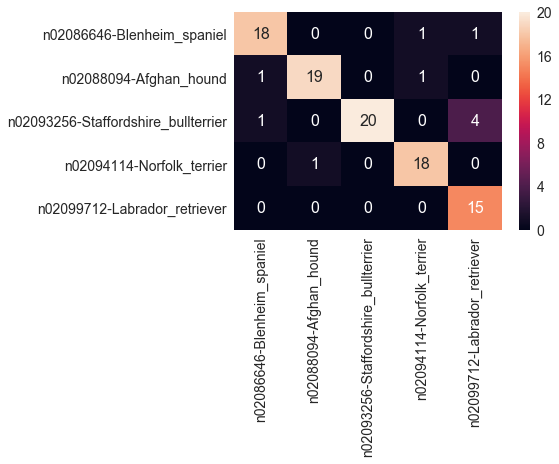

In [29]:
labels = ['n02086646-Blenheim_spaniel', 
          'n02088094-Afghan_hound', 
          'n02093256-Staffordshire_bullterrier',
          'n02094114-Norfolk_terrier',
          'n02099712-Labrador_retriever']
y_pred = model.predict_classes(validation_data)
y_true = np.argmax(validation_labels, axis=1)
print("f1 score: ", f1_score(y_true, y_pred, average='micro'))
predictions =  [labels[i] for i in y_pred]
real = [labels[i] for i in y_true]
cm = confusion_matrix(predictions, real)
df_cm = pd.DataFrame(cm, index = labels,
                  columns = labels)
sn.set(font_scale=1.4)#for label size
sn.heatmap(df_cm, annot=True,annot_kws={"size": 16})

We also have improved, our model, let's choose it, that's our final model.

# 5. Select and test final model

In [30]:
top_model_weights_path = 'fc_model_adam_2.h5'

Now we can play with our model importing weigths we previously stored after having trained our model.

In [31]:
img_width, img_height = 224, 224
labels = ['n02086646-Blenheim_spaniel', 
          'n02088094-Afghan_hound', 
          'n02093256-Staffordshire_bullterrier',
          'n02094114-Norfolk_terrier',
          'n02099712-Labrador_retriever']

def predict(image_path):

    num_classes = 5

    orig = cv2.imread(image_path)

    print("[INFO] loading and preprocessing image...")
    image = load_img(image_path, target_size=(img_width, img_height))
    image = img_to_array(image)

    # important! otherwise the predictions will be '0'
    image = image / 255

    image = np.expand_dims(image, axis=0)

    # build the VGG16 network
    model = applications.VGG16(include_top=False, weights='imagenet')

    # get the bottleneck prediction from the pre-trained VGG16 model
    bottleneck_prediction = model.predict(image)

    # build top model
    model = Sequential()
    model.add(Flatten(input_shape=bottleneck_prediction.shape[1:]))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.4))
    model.add(Dense(num_classes, activation='softmax'))

    model.load_weights(top_model_weights_path)

    # use the bottleneck prediction on the top model to get the final
    # classification
    class_predicted = model.predict_classes(bottleneck_prediction)

    probabilities = model.predict_proba(bottleneck_prediction)

    inID = class_predicted[0]

    label = labels[inID]

    # get the prediction label
    print("Image ID: {}, Label: {}".format(inID, label))

In [34]:
predict('./api/image/afghanhoundsf4.jpg')

[INFO] loading and preprocessing image...
Image ID: 1, Label: n02088094-Afghan_hound
